## Ice number evaluation
Comparisons with DeMott et al., 2010, and Patnaude, Diao, Liu, & Chu, 2021 (following the methods of Zhu, 2021)

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, re
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, average_and_wrap, mute_ax
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

import dask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
fb_dir ='feedbacks_soden/mod_by_me/output_jonahks/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(fb_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36602")
client

Client Scheduler: tcp://127.0.0.1:36602 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 2.15 GB


In [4]:
ls

AMWG_diag/                 Diagnostics_Output/  nimax_feedbacks/
caliop_olimpia/            feedbacks_soden/     NoresmDiagnostics/
caliop_olimpia_new/        figures/             NorESM_validation/
caliop_slfs/               git_repos/           nudging_dev/
caliop_slf_weight/         GOCCP_data/          olimpia_cosp/
CAM6_satcomp_wbf_1_inp_1/  inp_obs/             resolution_stuff/
CERES_EBAF/                inp_validation/      satcomp/
conspiracy_stuff/          mnth15runs/          satcomp_+4K/
convectivephase/           MODIS_COSP/          slf_validation/


## Load data into metric classes

In [5]:
allcases = SatComp_Metric(case_dir)

allcases.add_case('20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1', label="CAM6-Oslo")
allcases.add_case('CESM2_slfvars', label="CAM6")
allcases.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1', label="CAM6-OsloIce")

allcases.add_case("20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10",label='CAM6-Oslo \n Fit 1')
# allcases.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05',label='CAM6-OsloIce \n Fit 2')
allcases.add_case('20200629_morn_cam61satcomp_wbf_0.5_inp_0.05',label='CAM6-OsloIce \n Fit 2')
allcases.add_case('20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1',label='CAM6-OsloIce \n Fit 3')
allcases.add_case('20200713_CESM2_satcomp_wbf_1_inp_100',label="CAM6 \n Fit 4")

Loading GOCCP data...done.
Loading CALIOP SLFs...done
Loading CERES-EBAF fluxes...done.
Trying to load concatenated file for 20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1
20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1 load successfully.
Trying to load concatenated file for CESM2_slfvars
CESM2_slfvars load successfully.
Trying to load concatenated file for 20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1
20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1 load successfully.
Trying to load concatenated file for 20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10
20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10 load successfully.
Trying to load concatenated file for 20200629_morn_cam61satcomp_wbf_0.5_inp_0.05
20200629_morn_cam61satcomp_wbf_0.5_inp_0.05 load successfully.
Trying to load concatenated file for 20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1
20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1 load successfully.
Trying to load

In [6]:
ex_da = allcases.get_case('20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1').case_da

ice_conc = ex_da['AWNI'] / ex_da['FREQI']

avg_conc = ice_conc.mean(dim=['time','lon'])*1e-3

colorsf = plt.cm.Reds(np.linspace(0.0,1.0,9))

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


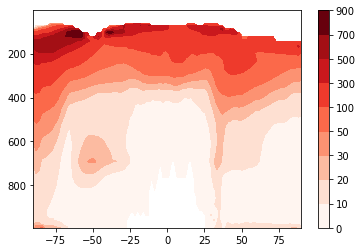

In [7]:
fig = plt.figure()

im = plt.contourf(avg_conc['lat'],avg_conc['lev'],avg_conc,colors=colorsf,levels=[0,10,20,30,50,100,300,500,700,900]) # Reds Set1
# im = plt.contourf(avg_conc['lat'],avg_conc['lev'],avg_conc,cmap='Reds',levels=[0,10,20,30,50,100,300,500,700,900]) # Reds Set1
# plt.contourf(avg_conc['lon'],avg_conc['lat'],avg_conc,**kwargs)

plt.colorbar(im,spacing='uniform')

# fig.
# avg_conc.plot(cmap='Reds',levels=[0,10,20,30,50,100,300,500,700,900])

plt.gca().invert_yaxis()

### Attempt with dask delayed (not sure why kernel is crashing with this little memory use...)

In [22]:
def plot_ice(da,ax):
    '''Wrapper to try and use dask and avoid kernel failures.'''
    
    awni  = da['AWNI' ].mean(dim=['time','lon'])
    freqi = da['FREQI'].mean(dim=['time','lon'])
    da.close()
    
    ice_conc = awni / freqi * 1e-3
    awni.close()
    freqi.close()
    
    
    im = ax.contourf(ice_conc['lat'],ice_conc['lev'],ice_conc,cmap='Reds',levels=[0,10,20,30,50,100,300,500,700,900])
    ice_conc.close()
    
    ax.invert_yaxis()
    

In [ ]:
figB,axs = plt.subplots(2,4,figsize=(12,8))

results = []

for ax,case_label in zip(axs.flat,allcases.cases):
    
    _da = allcases.get_case(case_label).case_da
    
    results.append(dask.delayed(plot_ice)(_da, ax))
results = dask.compute(*results)
# results = client.compute(*results)

figB

/opt/conda/lib/python3.7/site-packages/distributed/worker.py:3239: UserWarning: Large object of size 53.65 MB detected in task graph: 
  (<xarray.Dataset>
Dimensions:             (bnds: 2 ... x7fea3afd7a90>)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


### Test getting hyam and hybm coordinates from a specific run

In [8]:
hyam_path = 'satcomp/20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1/atm/hist/'
hyam_exfile = '20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1.cam.h0.2009-11.nc'

In [9]:
ex_ds = xr.open_dataset('%s/%s' % (hyam_path,hyam_exfile))

In [10]:
# These just have a vertical coordinate (no lat,lon, or time) so I can freely use them for all runs
hyam = ex_ds['hyam']
hybm = ex_ds['hybm']

 p(k) = a(k)*p0 + b(k)*ps. 
 
- a(k) is the hyam
- b(k) is the hybm
- p0 is the Scalar numeric value equal to the surface reference pressure. Must have the same units as ps. (I think that this is 1000mb)
- ps is An array of at least 2 dimensions equal to surface pressure data in Pa or hPa (mb). The two rightmost dimensions must be latitude and longitude. (This is the P0 model field)

In [11]:
_da = allcases.get_case('20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1').case_da

In [21]:
ps_tavg = _da['PS'].mean('time')
awni_tavg = _da['AWNI'].mean('time')
freqi_tavg = _da['FREQI'].mean('time')

In [22]:
P0 = 1000 # reference surface pressure (mb)
PS = ps_tavg # model surface pressure
newP = (hyam*P0 + hybm*PS)*1e-2 # kills the kernel sometimes??

In [23]:
newP

<xarray.DataArray (lev: 32, lat: 96, lon: 144)>
array([[[3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
         3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
        [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
         3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
        [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
         3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
        ...,
        [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
         3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
        [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
         3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
        [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
         3.64346569e-02, 3.64346569e-02, 3.64346569e-02]],

       [[7.59481965e-02, 7.59481965e-02, 7.59481965e-02, ...,
         7.59481965e-02, 7.59481965e-02, 7.59481965e-02],
        [7.59481965e-02, 7.59481965e-02, 7.59481965e-02, ...,
         7.59481965e-02, 7.59481965e-02, 7.59481965e-02],
        [7.59481965e-02, 7.59481965e-02, 7.59481965e-02, ...,
         7.59481965e-02, 7.59481965e-02, 7.59481965e-02],
        ...,
        [7.59481965e-02, 7.59481965e-02, 7.59481965e-02, ...,
         7.59481965e-02, 7.59481965e-02, 7.59481965e-02],
        [7.59481965e-02, 7.59481965e-02, 7.59481965e-02, ...,
         7.59481965e-02, 7.59481965e-02, 7.59481965e-02],
        [7.59481965e-02, 7.59481965e-02, 7.59481965e-02, ...,
         7.59481965e-02, 7.59481965e-02, 7.59481965e-02]],

       [[1.43566323e-01, 1.43566323e-01, 1.43566323e-01, ...,
         1.43566323e-01, 1.43566323e-01, 1.43566323e-01],
        [1.43566323e-01, 1.43566323e-01, 1.43566323e-01, ...,
         1.43566323e-01, 1.43566323e-01, 1.43566323e-01],
        [1.43566323e-01, 1.43566323e-01, 1.43566323e-01, ...,
         1.43566323e-01, 1.43566323e-01, 1.43566323e-01],
        ...,
        [1.43566323e-01, 1.43566323e-01, 1.43566323e-01, ...,
         1.43566323e-01, 1.43566323e-01, 1.43566323e-01],
        [1.43566323e-01, 1.43566323e-01, 1.43566323e-01, ...,
         1.43566323e-01, 1.43566323e-01, 1.43566323e-01],
        [1.43566323e-01, 1.43566323e-01, 1.43566323e-01, ...,
         1.43566323e-01, 1.43566323e-01, 1.43566323e-01]],

       ...,

       [[6.54618766e+02, 6.54618766e+02, 6.54618766e+02, ...,
         6.54618766e+02, 6.54618766e+02, 6.54618766e+02],
        [6.66407782e+02, 6.65322636e+02, 6.64236673e+02, ...,
         6.69781678e+02, 6.68660266e+02, 6.67530383e+02],
        [6.67471674e+02, 6.66039775e+02, 6.64616050e+02, ...,
         6.74041481e+02, 6.71766777e+02, 6.69609490e+02],
        ...,
        [9.65701617e+02, 9.65577214e+02, 9.65457418e+02, ...,
         9.65463066e+02, 9.65523187e+02, 9.65606940e+02],
        [9.66154492e+02, 9.66040716e+02, 9.65927386e+02, ...,
         9.66082555e+02, 9.66099945e+02, 9.66127144e+02],
        [9.66166085e+02, 9.66166085e+02, 9.66166085e+02, ...,
         9.66166085e+02, 9.66166085e+02, 9.66166085e+02]],

       [[6.70475338e+02, 6.70475338e+02, 6.70475338e+02, ...,
         6.70475338e+02, 6.70475338e+02, 6.70475338e+02],
        [6.82550710e+02, 6.81439206e+02, 6.80326864e+02, ...,
         6.86006558e+02, 6.84857907e+02, 6.83700579e+02],
        [6.83640444e+02, 6.82173764e+02, 6.80715457e+02, ...,
         6.90369833e+02, 6.88039876e+02, 6.85830188e+02],
        ...,
        [9.89114419e+02, 9.88986994e+02, 9.88864288e+02, ...,
         9.88870073e+02, 9.88931654e+02, 9.89017442e+02],
        [9.89578294e+02, 9.89461754e+02, 9.89345671e+02, ...,
         9.89504610e+02, 9.89522422e+02, 9.89550282e+02],
        [9.89590169e+02, 9.89590169e+02, 9.89590169e+02, ...,
         9.89590169e+02, 9.89590169e+02, 9.89590169e+02]],

       [[6.82992970e+02, 6.82992970e+02, 6.82992970e+02, ...,
         6.82992970e+02, 6.82992970e+02, 6.82992970e+02],
        [6.95294152e+02, 6.94161863e+02, 6.93028720e+02, ...,
         6.98814624e+02, 6.97644494e+02, 6.96465523e+02],
        [6.96404264e+02,

### Since the new P varies based on the surface pressure, each gridbox is on different pressure levels, requiring interpolation...

In [13]:
newP

<xarray.DataArray (lev: 32, time: 48, lat: 96, lon: 144)>
array([[[[3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         ...,
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02]],

        [[3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         ...,
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02]],

        [[3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         ...,
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02]],

        ...,

        [[3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         ...,
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02]],

        [[3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         ...,
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02]],

        [[3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
          3.64346569e-02, 3.64346569e-02, 3.64346569e-02],
         [3.64346569e-02, 3.64346569e-02, 3.64346569e-02, ...,
   

In [24]:
reorgP = newP.transpose(*['lat','lon','lev'])

In [18]:
newP[17,:,30,30]

<xarray.DataArray (time: 48)>
array([177.93853719, 177.88141451, 178.67034511, 178.19730417,
       178.16362506, 177.21288943, 177.42288625, 177.00473527,
       176.85301785, 177.35835254, 177.60599627, 178.24413751,
       178.19143992, 178.08464591, 178.77696426, 177.68143803,
       178.17431791, 177.73639524, 177.1138965 , 177.50325076,
       176.82330652, 177.40732445, 177.79135246, 177.38978549,
       177.61853179, 177.04148102, 177.84784299, 178.01789294,
       176.74809342, 177.08243665, 177.2522983 , 176.77081068,
       177.04528741, 177.84464186, 178.04697211, 177.60731438,
       178.06040879, 178.70223536, 178.30267246, 178.13917273,
       177.70759852, 177.27684478, 176.49813627, 177.55522204,
       177.12593436, 177.75697394, 177.50050693, 177.58902221])
Coordinates:
    lev      float64 322.2
  * time     (time) datetime64[ns] 2009-06-01 2009-07-01 ... 2013-05-01
    lat      float64 -33.16
    lon      float64 75.0

<xarray.DataArray (lev: 32)>
array([3.64346569e-02, 7.59481965e-02, 1.43566323e-01, 2.46122200e-01,
       3.59232500e-01, 4.31937501e-01, 5.16774990e-01, 6.15204982e-01,
       7.37509578e-01, 8.78212303e-01, 1.03317127e+00, 1.21547241e+00,
       1.42994039e+00, 1.68225080e+00, 1.53226348e+01, 4.47133998e+01,
       7.92901182e+01, 1.19967834e+02, 1.67823045e+02, 2.24122225e+02,
       2.90355310e+02, 3.61972350e+02, 4.30659787e+02, 4.91271046e+02,
       5.39626953e+02, 5.72178830e+02, 5.95311901e+02, 6.16878520e+02,
       6.36702554e+02, 6.54618766e+02, 6.70475338e+02, 6.82992970e+02])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
    lat      float64 -90.0
    lon      float64 0.0


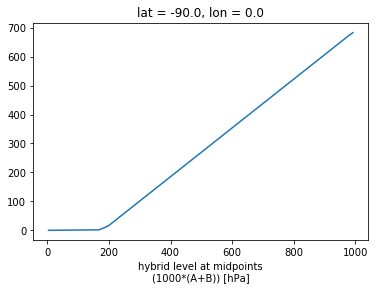

In [27]:
for latslice in reorgP:
    for lon in latslice:
        print(lon)
        lon.plot()
        break
    break

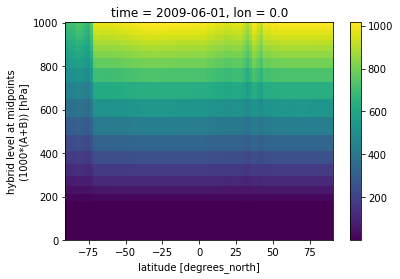

In [28]:
newP[:,0,:,0].plot()

In [21]:
targetP = _da['lev']

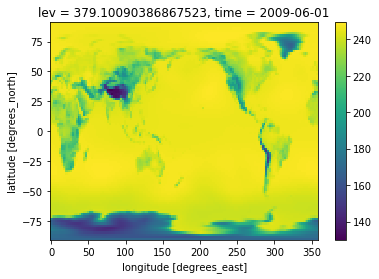

In [30]:
newP[18,0].plot()

In [32]:
newP.shape

(32, 48, 96, 144)

In [ ]:
newP.

In [ ]:
np.interp(targetP,)

In [35]:
from scipy.interpolate import interp1d

In [36]:
interp1d(targetP,newP,axis=0)

In [ ]:
ntime, nheight_in, nlat, nlon = (10, 20, 30, 40)

heights = np.linspace(0, 1, nheight_in)

t_in = np.random.normal(size=(ntime, nheight_in, nlat, nlon))
f_out = interp1d(heights, t_in, axis=1)

nheight_out = 50
new_heights = np.linspace(0, 1, nheight_out)
t_out = f_out(new_heights)

In [ ]:
newP.interp()

20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1
1.
2.
3.


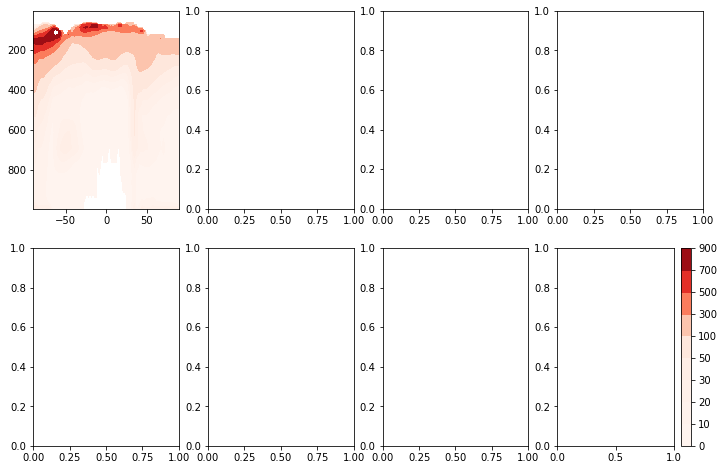

In [58]:
figB,axs = plt.subplots(2,4,figsize=(12,8))

for ax,case_label in zip(axs.flat,allcases.cases):
    print(case_label)
    
    _da = allcases.get_case(case_label).case_da

    print('1.')
#     temp_freqi = _da['FREQI'].mean(dim='time')
#     freqi = temp_freqi.mean('lon')
#     temp_freqi.close()
    
#     print('1b.')
#     temp_awni = _da['AWNI'].mean(dim='time')
#     awni = temp_awni.mean('lon')
#     temp_awni.close()
    
    awni  = _da['AWNI' ].mean(dim=['time','lon']) # this is the most intensive operation, where the kernel dies
    freqi = _da['FREQI'].mean(dim=['time','lon'])
    _da.close()
    
    print('2.')
    ice_conc = awni / freqi * 1e-3
    awni.close()
    freqi.close()
    
    
    print('3.')
    levels=[0,10,20,30,50,100,300,500,700,900]
    im = ax.contourf(ice_conc['lat'],ice_conc['lev'],ice_conc,cmap='Reds',levels=levels)
    ice_conc.close()
    
    ax.invert_yaxis()
    
    break
# plt.contourf(avg_conc['lon'],avg_conc['lat'],avg_conc,**kwargs)


figB.colorbar(im,ticks=levels)

# fig.
# avg_conc.plot(cmap='Reds',levels=[0,10,20,30,50,100,300,500,700,900])

# plt.gca().invert_yaxis()

In [20]:
_da['PS']

<xarray.DataArray 'PS' (time: 48, lat: 96, lon: 144)>
[663552 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2009-06-01 2009-07-01 ... 2013-05-01
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:     Surface pressure
    units:         Pa
    cell_methods:  time: mean

In [12]:
_da.nbytes

2720679576

In [13]:
awni.nbytes

12288

In [16]:
_da['AWNI' ].nbytes

84934656

In [6]:
_da['AWNI' ].dims

('time', 'lev', 'lat', 'lon')

In [14]:
freqi.nbytes

12288

In [17]:
ice_conc.nbytes

12288

In [1]:
figB,axs = plt.subplots(2,4,figsize=(12,8))

for ax,case_label in zip(axs.flat,allcases.cases):
    print(case_label)
    
    _da = allcases.get_case(case_label).case_da
    
    awni  = _da['AWNI' ].mean(dim=['time','lon'])
    freqi = _da['FREQI'].mean(dim=['time','lon'])
    _da.close()
    
    ice_conc = awni / freqi * 1e-3
    awni.close()
    freqi.close()
    
    
    im = ax.contourf(ice_conc['lat'],ice_conc['lev'],ice_conc,cmap='Reds',levels=[0,10,20,30,50,100,300,500,700,900])
    ice_conc.close()
    
    ax.invert_yaxis()
    
#     break
# plt.contourf(avg_conc['lon'],avg_conc['lat'],avg_conc,**kwargs)


plt.colorbar(im)

# fig.
# avg_conc.plot(cmap='Reds',levels=[0,10,20,30,50,100,300,500,700,900])

# plt.gca().invert_yaxis()

NameError: name 'plt' is not defined

In [ ]:
# figB,axs = plt.subplots(2,4,figsize=(12,8))

for case_label in allcases.cases:
    print(case_label)
    
    _fig = plt.figure()
    
    _da = allcases.get_case(case_label).case_da
    
    awni  = _da['AWNI' ].mean(dim=['time','lon'])
    freqi = _da['FREQI'].mean(dim=['time','lon'])
    _da.close()
    
    ice_conc = awni / freqi * 1e-3
    awni.close()
    freqi.close()
    
    
    im = plt.contourf(ice_conc['lat'],ice_conc['lev'],ice_conc,cmap='Reds',levels=[0,10,20,30,50,100,300,500,700,900])
    ice_conc.close()
    
    plt.gca().invert_yaxis()
    plt.colorbar(im)
    
#     break
# plt.contourf(avg_conc['lon'],avg_conc['lat'],avg_conc,**kwargs)


# plt.colorbar(im)

# fig.
# avg_conc.plot(cmap='Reds',levels=[0,10,20,30,50,100,300,500,700,900])

# plt.gca().invert_yaxis()

20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1
CESM2_slfvars
20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1
20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10
